In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt

Using TensorFlow backend


In [2]:
# load preprocessed train, validation splits - for X (features)
preprocessed_saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetection/saved_data/train_val_test_preprocessed/'
# for y - (labels)
split_saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetection/saved_data/train_val_split/'

X_train = np.load(preprocessed_saved_dir + 'X_train_preprocessed.npy')

X_val = np.load(preprocessed_saved_dir + 'X_val_preprocessed.npy')

y_train = np.load(split_saved_dir + 'y_train.npy')

y_val = np.load(split_saved_dir + 'y_val.npy')

In [3]:
y_train, y_val

(array([1, 0, 2, ..., 0, 6, 8]), array([0, 1, 6, ..., 4, 0, 8]))

In [4]:
# one hot encoding the lebels
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)
y_train_encoded, y_val_encoded

(array([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32))

In [5]:
def build_model(hp):
    # pretrained model - MobileNetV2
    # all should be numpy arrays or tensors before giving it to MobileNetV2
    """
    tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,                 # Shape of input data (MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.) 
    alpha=1.0,                        # Width multiplier for controlling network width (default is 1.0)
    include_top=True,                 # Include fully connected top layers (default is True)
    weights='imagenet',               # Weight initialization ('imagenet' for pre-trained weights, None for random initialization)
    input_tensor=None,                # Optional input tensor (default is None)
    pooling=None,                     # Pooling type for the last layer ('avg', 'max', or None; default is None)
    classes=1000,                     # Number of output classes (default is 1000 for ImageNet)
    classifier_activation='softmax',   # Activation function for output layer (default is 'softmax')
    **kwargs                          # Additional keyword arguments
    )
    """
    
    # we dont have to set anything and keep its default values
    MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
    
    # Make all layers in the model non-trainable - freeze
    for layer in MobileNetV2_model.layers:
        layer.trainable = False
        
    base_input = MobileNetV2_model.layers[0].input
    base_output = MobileNetV2_model.layers[-3].output
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_output)
    
    # Hyperparameter: Include Dense Layer (True or False)
    include_dense = hp.Boolean('include_dense')

    if include_dense:
        # Hyperparameter: Number of neurons in the dense layer
        num_neurons = hp.Int('num_neurons', min_value=32, max_value=512, step=32)
        dense_layer = tf.keras.layers.Dense(num_neurons, activation='relu')(global_average_layer)
        # Hyperparameter: Dropout rate
        '''
        Dropout is a regularization technique that helps prevent overfitting by randomly 
        setting a fraction of the input units to 0 during training.
        '''
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        dropout_layer = tf.keras.layers.Dropout(dropout_rate)(dense_layer)
        
        final_output = tf.keras.layers.Dense(10, activation='softmax')(dropout_layer)
    else:
        final_output = tf.keras.layers.Dense(10, activation='softmax')(global_average_layer)
    
    distraction_detection_model = tf.keras.Model(inputs=base_input, outputs=final_output)
    
    # Hyperparameter: Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    distraction_detection_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy', # Use categorical cross-entropy for multi-class classification
        metrics=['accuracy']
    )
    
    return distraction_detection_model

In [6]:
# Initialize the Keras Tuner RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # The metric to optimize
    max_trials=10,             # Number of hyperparameter combinations to try
    directory='tuner_dir',      # Directory for saving results
    project_name='distraction_detection'  # Name of the project
)

In [7]:
# Hyperparameter: Batch size
batch_size = 32

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)
    
# Start the hyperparameter search using your training data with early stopping
tuner.search(X_train, y_train_encoded,
             epochs=50, 
             validation_data=(X_val, y_val_encoded), 
             batch_size=batch_size,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Trial 10 Complete [02h 29m 38s]
val_accuracy: 0.7320553064346313

Best val_accuracy So Far: 0.9915292263031006
Total elapsed time: 1d 07h 01m 02s


In [8]:
tuner.results_summary()

Results summary
Results in tuner_dir\distraction_detection
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
include_dense: True
learning_rate: 0.0001
num_neurons: 160
dropout_rate: 0.2
Score: 0.9915292263031006

Trial 08 summary
Hyperparameters:
include_dense: True
learning_rate: 0.001
num_neurons: 256
dropout_rate: 0.4
Score: 0.9897458553314209

Trial 02 summary
Hyperparameters:
include_dense: True
learning_rate: 0.001
num_neurons: 192
dropout_rate: 0.30000000000000004
Score: 0.9852875471115112

Trial 03 summary
Hyperparameters:
include_dense: False
learning_rate: 0.001
num_neurons: 96
dropout_rate: 0.0
Score: 0.9826125502586365

Trial 00 summary
Hyperparameters:
include_dense: True
learning_rate: 0.001
num_neurons: 32
dropout_rate: 0.0
Score: 0.9808292388916016

Trial 05 summary
Hyperparameters:
include_dense: False
learning_rate: 0.01
num_neurons: 32
dropout_rate: 0.30000000000000004
Score: 0.975479245185852

Trial 07 summary


In [9]:
tuner.get_best_hyperparameters()[0].values

{'include_dense': True,
 'learning_rate': 0.0001,
 'num_neurons': 160,
 'dropout_rate': 0.2}

In [10]:
# 1st best model
best_model = tuner.get_best_models(num_models=1)[0]

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)
    
# Train the model with the best hyperparameters
history_of_model = best_model.fit(X_train,                   
               y_train_encoded,
               epochs=100, 
               validation_data=(X_val, y_val_encoded), 
               batch_size=32,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/100
631/631 [==============================] - 656s 1s/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.0462 - val_accuracy: 0.9889 - lr: 1.0000e-04
Epoch 2/100
631/631 [==============================] - 625s 991ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.0502 - val_accuracy: 0.9897 - lr: 1.0000e-04
Epoch 3/100
631/631 [==============================] - 598s 948ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.0473 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 4/100
631/631 [==============================] - 610s 966ms/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.0479 - val_accuracy: 0.9911 - lr: 1.0000e-04
Epoch 5/100
631/631 [==============================] - 620s 983ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0436 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 6/100
631/631 [==============================] - 620s 982ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.0513 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 7/100
631/631

In [11]:
# Save the model architecture and weights
save_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetection/saved_data/models/'

best_model.save(save_dir + 'distration_detection_model_hpt_best_model.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import pickle

# Save the history object to a file
with open(save_dir + 'distraction_detection_hpt_best_model_history.pkl', 'wb') as file:
    pickle.dump(history_of_model.history, file)

In [15]:
training_loss = history_of_model.history['loss']
validation_loss = history_of_model.history['val_loss']

training_accuracy = history_of_model.history['accuracy']
validation_accuracy = history_of_model.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

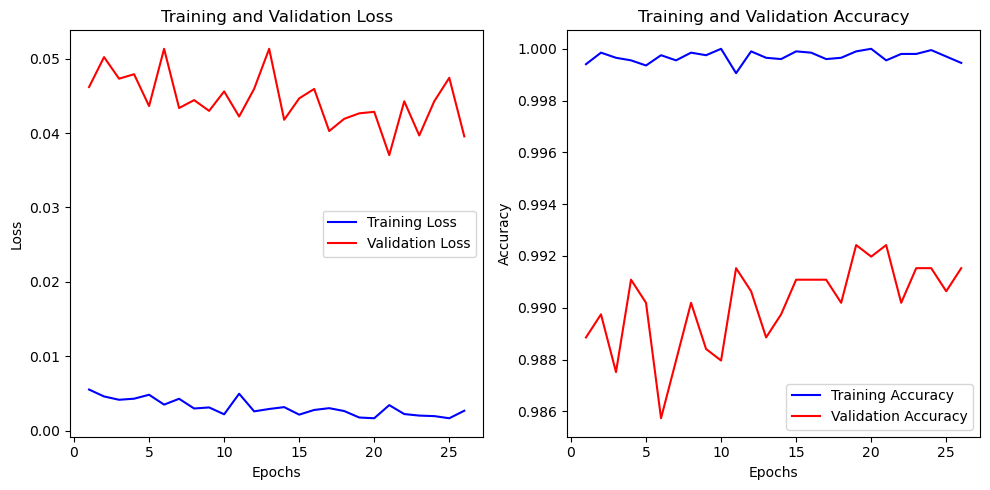

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# 2nd best model
best_model_2 = tuner.get_best_models(num_models=2)[1]

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)
    
# Train the model with the best hyperparameters
history_of_model_2 = best_model_2.fit(X_train,                   
               y_train_encoded,
               epochs=100, 
               validation_data=(X_val, y_val_encoded), 
               batch_size=32,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/100
631/631 [==============================] - 328s 514ms/step - loss: 0.0481 - accuracy: 0.9832 - val_loss: 0.0500 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 2/100
631/631 [==============================] - 341s 541ms/step - loss: 0.0426 - accuracy: 0.9851 - val_loss: 0.0730 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 3/100
631/631 [==============================] - 353s 560ms/step - loss: 0.0465 - accuracy: 0.9827 - val_loss: 0.0576 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 4/100
631/631 [==============================] - 357s 566ms/step - loss: 0.0507 - accuracy: 0.9833 - val_loss: 0.0689 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/100
631/631 [==============================] - 379s 601ms/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.0633 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 6/100
631/631 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9864
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
631/631 [==================

In [18]:
training_loss = history_of_model_2.history['loss']
validation_loss = history_of_model_2.history['val_loss']

training_accuracy = history_of_model_2.history['accuracy']
validation_accuracy = history_of_model_2.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

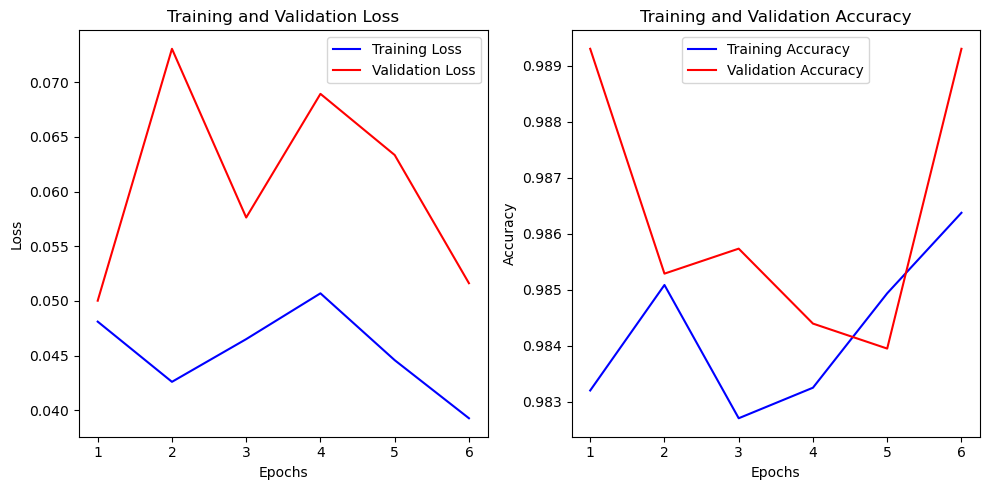

In [19]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()